<a href="https://colab.research.google.com/github/RajeswariKumaran/SSLMethodsAnalysis/blob/main/vat_minentropy_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#entropy minimisation + rampup + vat

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
import math

def ramp_up(epoch, max_lambda_vat, rampup_length):
    if rampup_length == 0:
        return max_lambda_vat
    else:
        epoch = min(epoch, rampup_length)
        phase = 1.0 - epoch / rampup_length
        return max_lambda_vat * math.exp(-5.0 * phase * phase)


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model = SimpleCNN().cuda()
model.eval()  # Important for VAT

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        if alpha is not None:
            self.register_buffer('alpha', alpha)  # important!
        else:
            self.alpha = None
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        probs = F.softmax(inputs, dim=1)
        pt = probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        focal_factor = (1 - pt) ** self.gamma

        if self.alpha is not None:
            at = self.alpha.gather(0, targets)  # this is the line causing the error
            loss = -at * focal_factor * torch.log(pt + 1e-8)
        else:
            loss = -focal_factor * torch.log(pt + 1e-8)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [ ]:
# Corrected KL divergence definition
def kl_div(logits1, logits2):
    p = F.softmax(logits1, dim=1)
    log_p = F.log_softmax(logits1, dim=1)
    log_q = F.log_softmax(logits2, dim=1)
    return F.kl_div(log_q, p, reduction='batchmean')

In [ ]:
# model = SimpleCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lambda_vat = 1.0         # standard VAT weight

# Initialize criterion and model
alpha = torch.ones(10)
# alpha[0] = 2.0  # airplane
# alpha[2] = 2.0  # bird
# alpha[3] = 2.0  # cat
# alpha[5] = 2.0  # dog
criterion_sup = FocalLoss(alpha=alpha, gamma=2)

# Move model to GPU
model = model.to(device)
criterion_sup = criterion_sup.to(device)  # ✅ This is required!

In [ ]:
# =====================================
# Generate virtual adversarial noise
# =====================================
def generate_virtual_adversarial_perturbation(model, x, xi=1e-6, eps=3.0, ip=1):
    with torch.no_grad():
        pred = model(x)

    d = torch.randn_like(x)


    # Ensure epsilon is a tensor on the same device as x
    epsilon_tensor = torch.tensor(eps).to(x.device)

    for _ in range(ip):
        d = xi * F.normalize(d, p=2, dim=(1, 2, 3))
        d.requires_grad_()
        pred_hat = model(x + d)
        loss = kl_div(pred.detach(), pred_hat)
        grad = torch.autograd.grad(loss, d)[0]
        d = F.normalize(grad, p=2, dim=(1, 2, 3)).detach()

    # Use the epsilon tensor for multiplication
    r_adv = epsilon_tensor * d
    return r_adv


# ================================
# VAT Loss function
# ================================
def virtual_adversarial_loss(model, x, xi=1e-6, eps=6.0, ip=1):
    r_adv = generate_virtual_adversarial_perturbation(model, x, xi, eps, ip)
    pred = model(x)
    pred_hat = model(x + r_adv)
    return kl_div(pred, pred_hat)

In [ ]:
def train_one_epoch(model, labeled_loader, unlabeled_loader, optimizer,
                    criterion_sup, epoch, total_epochs,
                    max_lambda_vat, max_lambda_entropy,
                    device):
    model.train()

    total_loss_epoch = 0
    total_correct = 0
    total_samples = 0

    # Compute current ramp-up weights
    lambda_vat = ramp_up(epoch, max_lambda_vat, rampup_length=int(0.3 * total_epochs))
    lambda_entropy = ramp_up(epoch, max_lambda_entropy, rampup_length=int(0.3 * total_epochs))

    for (x_l, y_l), (x_u, _) in zip(labeled_loader, unlabeled_loader):
        x_l, y_l = x_l.to(device), y_l.to(device)
        x_u = x_u.to(device)

        optimizer.zero_grad()

        # ----- Supervised loss -----
        logits_l = model(x_l)
        loss_sup = criterion_sup(logits_l, y_l)

        # ----- VAT loss -----
        r_adv = generate_virtual_adversarial_perturbation(model, x_u)
        logits_u = model(x_u)
        logits_u_perturbed = model(x_u + r_adv)

        probs_u = F.softmax(logits_u.detach(), dim=1)
        log_probs_perturbed = F.log_softmax(logits_u_perturbed, dim=1)
        loss_vat = F.kl_div(log_probs_perturbed, probs_u, reduction='batchmean')

        # ----- Entropy minimization loss -----
        loss_entropy = entropy_minimization_loss(logits_u)

        # ----- Total loss -----
        total_loss = loss_sup + lambda_vat * loss_vat + lambda_entropy * loss_entropy
        total_loss.backward()
        optimizer.step()

        # Track stats
        preds = logits_l.argmax(dim=1)
        total_correct += (preds == y_l).sum().item()
        total_samples += y_l.size(0)
        total_loss_epoch += total_loss.item() * y_l.size(0)

    avg_loss = total_loss_epoch / total_samples
    accuracy = total_correct / total_samples

    print(f"[Epoch {epoch}] Acc: {accuracy:.4f}, Sup: {loss_sup.item():.4f}, VAT: {loss_vat.item():.4f}, Ent: {loss_entropy.item():.4f}, λ_vat: {lambda_vat:.4f}, λ_ent: {lambda_entropy:.4f}")
    return avg_loss, accuracy


In [ ]:
# new including entropy thresholding
def train_one_epoch(model, labeled_loader, unlabeled_loader, optimizer,
                    criterion_sup, epoch, total_epochs,
                    max_lambda_vat, max_lambda_entropy,
                    entropy_threshold, warmup_epochs,
                    device):

    model.train()
    total_loss_epoch = 0
    total_correct = 0
    total_samples = 0

    # Ramp-up schedules
    rampup_length = int(0.7 * total_epochs)
    rampup_length = 15
    lambda_vat = ramp_up(epoch, max_lambda_vat, rampup_length)
    lambda_entropy = ramp_up(epoch, max_lambda_entropy, rampup_length)

    # Override during warmup
    if epoch < warmup_epochs:
        lambda_vat = 0.0
        lambda_entropy = 0.0

    for (x_l, y_l), (x_u, _) in zip(labeled_loader, unlabeled_loader):
        x_l, y_l = x_l.to(device), y_l.to(device)
        x_u = x_u.to(device)

        optimizer.zero_grad()

        # Supervised loss
        logits_l = model(x_l)
        loss_sup = criterion_sup(logits_l, y_l)

        # Forward pass on unlabeled data
        logits_u = model(x_u)
        probs_u = F.softmax(logits_u, dim=1)
        # print("probs_u[0]:", probs_u[0])

        # Entropy minimization
        loss_entropy = entropy_minimization_loss(logits_u)

        # Initialize VAT loss
        loss_vat = torch.tensor(0.0, device=device)



        entropies = entropy_per_sample(probs_u)
        # print(f"Entropy stats - min: {entropies.min().item():.4f}, max: {entropies.max().item():.4f}, mean: {entropies.mean().item():.4f}")
        # print(f"Entropy threshold: {entropy_threshold}")
        mask = entropies < entropy_threshold
        # print(f"Number of confident samples: {mask.sum().item()}")



        # Apply VAT only if after warmup
        if lambda_vat > 0:
            entropies = -torch.sum(probs_u * torch.log(probs_u + 1e-8), dim=1)
            mask = entropies < entropy_threshold

            # if mask.any():

            #     x_confident = x_u[mask]

            #     with torch.no_grad():
            #         logits_orig = model(x_confident)  # <-- this is what you need
            #         logits_orig_detached = logits_orig.detach()

            #     # Generate adversarial perturbation
            #     r_adv = generate_virtual_adversarial_perturbation(model, x_confident)
            #     logits_perturbed = model(x_confident + r_adv)

            #     # Consistency-style VAT loss (MSE on logits)
            #     loss_vat = F.mse_loss(logits_perturbed, logits_orig_detached)
            # else:
            #     mask = torch.tensor([], dtype=torch.bool, device=device)  # To avoid crash in logging
            if mask.any():
                x_confident = x_u[mask]
                with torch.no_grad():
                    probs_confident = probs_u[mask]

                # Generate VAT perturbation

                r_adv = generate_virtual_adversarial_perturbation(model, x_confident)
                logits_perturbed = model(x_confident + r_adv)
                probs_perturbed = F.softmax(logits_perturbed, dim=1)

                loss_vat = F.kl_div(probs_perturbed.log(), probs_confident, reduction='batchmean')



                # Optional debug
                kl_per_sample = F.kl_div(probs_perturbed.log(), probs_confident, reduction='none').sum(dim=1)
            else:
                mask = torch.tensor([], dtype=torch.bool, device=device)  # To avoid crash in logging
        else:
            entropies = torch.tensor([0.0], device=device)
            mask = torch.tensor([], dtype=torch.bool, device=device)

        # Total loss
        total_loss = loss_sup + lambda_vat * loss_vat + lambda_entropy * loss_entropy
        total_loss.backward()
        optimizer.step()

        # Stats
        preds = logits_l.argmax(dim=1)
        total_correct += (preds == y_l).sum().item()
        total_samples += y_l.size(0)
        total_loss_epoch += total_loss.item() * y_l.size(0)

    # Logging
    avg_loss = total_loss_epoch / total_samples
    accuracy = total_correct / total_samples

    #print(f"[Epoch {epoch}] Entropy stats — min: {entropies.min():.4f}, max: {entropies.max():.4f}, mean: {entropies.mean():.4f}, median: {entropies.median():.4f}, conf: {mask.sum().item()}")

    # print(f"[Epoch {epoch}] Entropy stats — min: {entropies.min().item():.4f}, max: {entropies.max().item():.4f}, mean: {entropies.mean().item():.4f}, median: {entropies.median().item():.4f}, conf: {mask.sum().item()}")
    print(f"[Epoch {epoch}] Acc: {accuracy:.4f}, Sup: {loss_sup.item():.4f}, VAT: {loss_vat.item():.4f}, Ent: {loss_entropy.item():.4f}, λ_vat: {lambda_vat:.4f}, λ_ent: {lambda_entropy:.4f}, Conf: {mask.sum().item()}")

    return avg_loss, accuracy



In [ ]:
max_lambda_vat = 0.2
max_lambda_entropy = 0.06
total_epochs = 30


In [ ]:
import torch
import torch.nn.functional as F

def entropy_minimization_loss(logits):
    """
    Computes mean entropy over the batch.

    Args:
        logits (Tensor): shape (batch_size, num_classes), raw model outputs

    Returns:
        Tensor: scalar tensor representing the mean entropy loss
    """
    probs = F.softmax(logits, dim=1)                    # Convert logits to probabilities
    log_probs = F.log_softmax(logits, dim=1)            # Log probabilities for numerical stability
    entropy = -torch.sum(probs * log_probs, dim=1)      # Entropy per sample
    return entropy.mean()                               # Mean entropy over the batch


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# === 1. DATASET SETUP (CIFAR-10) ===

def get_cifar10_dataloaders(num_labeled=10000, batch_size=64):
    # transform = transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize((0.5,), (0.5,))
    # ])
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)

    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

    full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Randomly split labeled/unlabeled
    indices = np.arange(len(full_trainset))
    np.random.shuffle(indices)
    labeled_indices = indices[:num_labeled]
    unlabeled_indices = indices[num_labeled:]

    labeled_set = Subset(full_trainset, labeled_indices)
    unlabeled_set = Subset(full_trainset, unlabeled_indices)

    labeled_loader = DataLoader(labeled_set, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return labeled_loader, unlabeled_loader, test_loader

In [ ]:
print(torch.cuda.is_available())
!nvidia-smi


True
Thu Oct  2 13:09:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             32W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA available: True
GPU name: Tesla T4


In [ ]:
import torch

def entropy_per_sample(probs: torch.Tensor) -> torch.Tensor:
    """
    Computes entropy per sample for a batch of probabilities.

    Args:
        probs: Tensor of shape (batch_size, num_classes), values should sum to 1 along dim=1.

    Returns:
        Tensor of shape (batch_size,) with entropy per sample.
    """
    return -torch.sum(probs * torch.log(probs.clamp(min=1e-8)), dim=1)


In [ ]:
labeled_loader, unlabeled_loader, test_loader = get_cifar10_dataloaders(num_labeled=4000, batch_size=64)

100%|██████████| 170M/170M [03:42<00:00, 767kB/s]


In [ ]:

num_epochs = 30
entropy_threshold = 2.0     # allow more samples into VAT
max_lambda_vat = 0.5
max_lambda_entropy = 0.06
max_lambda_entropy = 0.1
warmup_epochs = 5            # skip VAT early on

model.to(device)  # Move model to the device
ramp_length = 30
for epoch in range(num_epochs):
    if epoch < 10:
      entropy_threshold = 2.0
    elif epoch < 20:
      entropy_threshold = 1.5
    else:
      entropy_threshold = 1.0

    entropy_threshold = max(0.5, 2.0 - epoch / total_epochs * 1.5)
    avg_loss, accuracy = train_one_epoch(
        model,
        labeled_loader,
        unlabeled_loader,
        optimizer,
        criterion_sup,
        epoch,
        total_epochs=num_epochs,
        max_lambda_vat=max_lambda_vat,
        max_lambda_entropy=max_lambda_entropy,
        entropy_threshold=entropy_threshold,
        warmup_epochs=warmup_epochs,
        # entropy_threshold=exp_entropy_threshold(epoch, ramp_length), #0.9,  # lower = stricter confidence
        device=device
    )


    # model, labeled_loader, unlabeled_loader, optimizer,
    #                 criterion_sup, epoch, total_epochs,
    #                 max_lambda_vat, max_lambda_entropy,
    #                 device):


    if (accuracy > 0.93):
      break


[Epoch 0] Acc: 0.6530, Sup: 0.4562, VAT: 0.0000, Ent: 1.3361, λ_vat: 0.0000, λ_ent: 0.0000, Conf: 0
[Epoch 1] Acc: 0.6710, Sup: 0.4589, VAT: 0.0000, Ent: 1.4079, λ_vat: 0.0000, λ_ent: 0.0000, Conf: 0
[Epoch 2] Acc: 0.6797, Sup: 0.4980, VAT: 0.0000, Ent: 1.2536, λ_vat: 0.0000, λ_ent: 0.0000, Conf: 0
[Epoch 3] Acc: 0.6693, Sup: 0.3147, VAT: 0.0000, Ent: 1.3482, λ_vat: 0.0000, λ_ent: 0.0000, Conf: 0
[Epoch 4] Acc: 0.6717, Sup: 0.4393, VAT: 0.0000, Ent: 1.2465, λ_vat: 0.0000, λ_ent: 0.0000, Conf: 0
[Epoch 5] Acc: 0.6805, Sup: 0.3701, VAT: 0.1406, Ent: 1.3310, λ_vat: 0.0542, λ_ent: 0.0108, Conf: 54
[Epoch 6] Acc: 0.6755, Sup: 0.5397, VAT: 0.1354, Ent: 1.2200, λ_vat: 0.0826, λ_ent: 0.0165, Conf: 52
[Epoch 7] Acc: 0.6785, Sup: 0.5846, VAT: 0.1672, Ent: 1.2315, λ_vat: 0.1206, λ_ent: 0.0241, Conf: 52
[Epoch 8] Acc: 0.6780, Sup: 0.5427, VAT: 0.1523, Ent: 1.1287, λ_vat: 0.1683, λ_ent: 0.0337, Conf: 54
[Epoch 9] Acc: 0.6813, Sup: 0.5041, VAT: 0.1549, Ent: 1.3083, λ_vat: 0.2247, λ_ent: 0.0449, Conf

In [ ]:
# Evaluation Function with Metrics & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def evaluation_output(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()

    acc = 100 * np.mean(y_pred == y_true)
    print(f"\n✅ Test Accuracy: {acc:.2f}%")
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ],
                yticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


✅ Test Accuracy: 59.89%

📊 Classification Report:
              precision    recall  f1-score   support

    airplane       0.58      0.66      0.62      1000
  automobile       0.71      0.72      0.71      1000
        bird       0.45      0.51      0.48      1000
         cat       0.45      0.41      0.43      1000
        deer       0.59      0.44      0.50      1000
         dog       0.51      0.58      0.54      1000
        frog       0.69      0.67      0.68      1000
       horse       0.64      0.65      0.65      1000
        ship       0.71      0.66      0.69      1000
       truck       0.69      0.69      0.69      1000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000



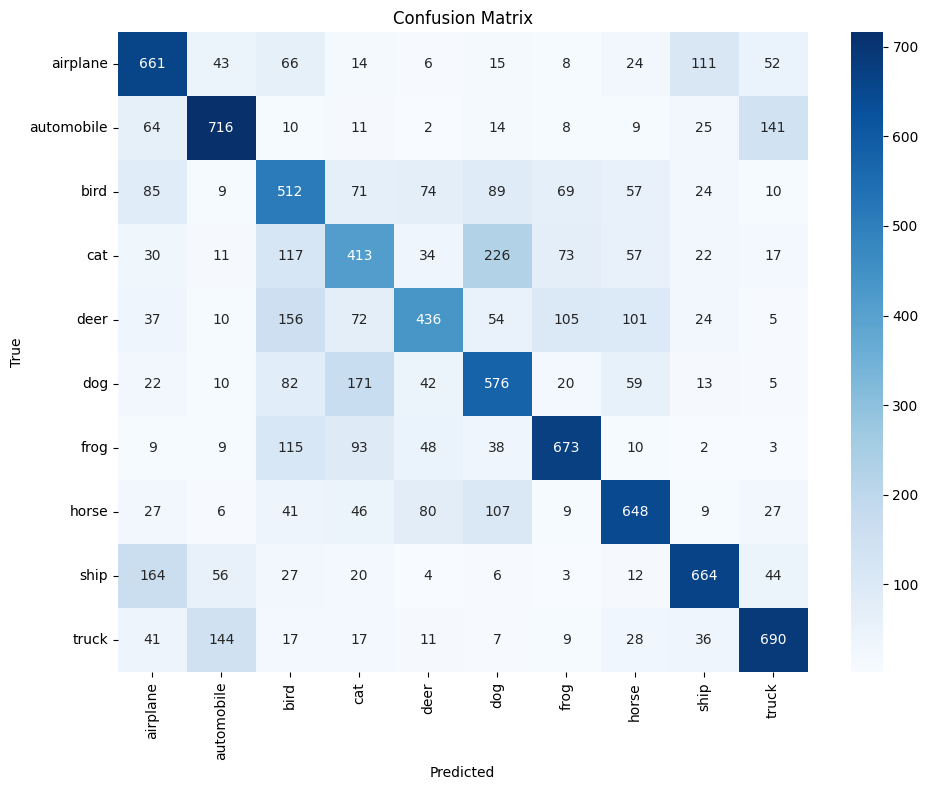

In [ ]:
evaluation_output(model, test_loader, device)